In [1]:
from utils import *
from modeling import *
from plotting import *
import seaborn as sns

%load_ext autoreload
%autoreload 2

In [2]:
hdu = fits.open("./data/coadd_SloanG_NGC_5907.fits")[0]
data = hdu.data
header = hdu.header
ZP = np.float(hdu.header["REFZP"])
pixel_scale = 2.5

header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 5750                                                  
NAXIS2  =                 4250                                                  
CTYPE1  = 'RA---TAN'                                                            
CRPIX1  =               2875.5                                                  
CRVAL1  =              228.975                                                  
CTYPE2  = 'DEC--TAN'                                                            
CRPIX2  =               2125.5                                                  
CRVAL2  =       56.32916666667                                                  
CD1_1   =  -0.0006944444444444                                                  
CD1_2   =                  0

In [3]:
res = load_nested_fitting_result(filename='./real/3p/NGC5907-G-fit_best_X3100Y1400_3p_2.res')

fit_res = res['fit_res']
R_scale = res['R_scale']
r_core = res['r_core']
image_size = res['image_size']
image_bounds0 = res['image_bounds0']

patch_Xmin0, patch_Ymin0, patch_Xmax0, patch_Ymax0 = image_bounds0

tab_catalog_match = Table.read("./Measure/NGC5907-G-catalog_match_r15mag.txt", format="ascii")
tab_target = crop_catalog(tab_catalog_match, keys=("X_IMAGE_PS", "Y_IMAGE_PS"), bounds=image_bounds0)

table_res_Rnorm = Table.read("./Measure/NGC5907-G-norm_%dpix_r15mag_X%dY%d.txt"\
                                 %(R_scale, patch_Xmin0, patch_Ymin0), format="ascii")

res_thumb = load_thumbs('./Measure/NGC5907-G-thumbnail_r15mag_X%dY%d'%(patch_Xmin0, patch_Ymin0))

Read thumbs from: ./Measure/NGC5907-G-thumbnail_r15mag_X3100Y1400.pkl


In [4]:
tab_target[:10]

NUMBER,FLUX_AUTO,X_IMAGE,Y_IMAGE,X_WORLD,Y_WORLD,FWHM_IMAGE,FLAGS,MAG_AUTO,ID_PS,gmag_PS,rmag_PS,X_IMAGE_PS,Y_IMAGE_PS
int64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,float64,float64
19063,6369070.0,3466.0796,1721.5258,228.24070208,56.046451325,7.07,6,10.08596,53379,7.754,6.6749,3466.0151,1721.6087
19617,5273856.0,3670.7646,1693.4302,227.98675202,56.025171198,6.63,6,10.29083,56898,7.839,7.968,3670.3764,1693.3941
18466,3842712.0,3321.3972,1824.0864,228.41955121,56.118606551,5.57,4,10.63456,53492,7.9324,8.6055,3321.2541,1824.2012
20822,1571271.0,3834.8767,1565.9124,227.78560648,55.934841547,3.93,4,11.60553,54780,10.4674,10.4994,3834.8505,1565.9065
16517,1554580.0,3497.1108,2059.6765,228.19737532,56.281019314,9.2,4,11.61712,58117,11.269,10.998,3497.8032,2060.6086
16430,1538869.0,3322.2563,2066.9353,228.41602509,56.287237808,4.17,4,11.62815,57766,10.611,10.244,3322.3262,2066.843
21048,1433815.0,3634.0322,1540.8929,228.03497774,55.919617353,3.82,6,11.70492,52759,11.6498,10.4833,3634.1619,1540.8524
16683,1361611.0,3652.0815,2038.4492,228.00391739,56.264914082,4.03,4,11.76102,58021,11.104,10.871,3651.9928,2038.4448
21360,1023345.0,3926.0103,1503.4731,227.67412291,55.890354676,3.36,4,12.0711,54994,12.1714,10.7379,3925.889,1503.9096


In [5]:
table_res_Rnorm[:10]

NUMBER,X_IMAGE,Y_IMAGE,Imean,Imed,Istd,Isky,Iflag
int64,float64,float64,float64,float64,float64,float64,float64
19063,3466.0796,1721.5258,1624.1267667051095,1677.9145153164727,160.1695297703109,466.6630124965428,0.0
19617,3670.7646,1693.4302,1251.7240322395473,1256.1263020332547,117.64350797010621,465.5809074302278,0.0
18466,3321.3972,1824.0864,922.3059042783748,914.7576312463036,75.04187823044396,464.5785602056093,0.0
20822,3834.8767,1565.9124,527.8020679216814,526.4156161814869,6.614787389121824,462.68148842939206,0.0
16517,3497.1108,2059.6765,511.13418377881055,510.520096987329,9.13156236803425,462.494035253127,0.0
16430,3322.2563,2066.9353,534.8079071242926,535.2837027053663,11.616072899038642,462.59257069842147,0.0
21048,3634.0322,1540.8929,520.3220965148925,520.5352351072893,8.58965691171451,464.69777529788587,0.0
16683,3652.0815,2038.4492,517.6728926954762,514.5665214056881,10.10879151944741,462.2048912795654,0.0
21360,3926.0103,1503.4731,489.058487863521,487.84584824950554,5.800219531526137,461.1704293824606,0.0


In [6]:
psf = PSF_Model(params={"fwhm":2.28*pixel_scale, "beta":10, "frac":0.3, 'theta_0':5},
                aureole_model='multi-power')
psf.make_grid(image_size, pixel_scale=pixel_scale)

psf_fit, params = make_psf_from_fit(fit_res, psf, n_out=3, theta_out=1200)

/home/qliu/Desktop/PSF/utils.py:439: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(r[r>3*r_core], np.log10(z[r>3*r_core]), color=color, s=3, alpha=0.1, zorder=1)


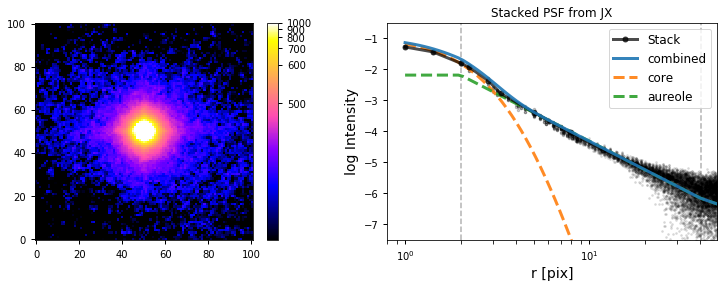

In [7]:
PSF_JX_p = fits.getdata("./med_psf_JX.fits") * 10 + psf_fit.bkg

fig = plt.figure(figsize=(13,4))
ax1 = plt.subplot(121)
im = ax1.imshow(PSF_JX_p, norm=norm1, vmin=psf_fit.bkg, vmax=1e3); colorbar(im)

ax2 = plt.subplot(122)
r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(abs(PSF_JX_p-psf_fit.bkg)/1e6, cen=(50,50), 
                                              ZP=ZP, sky_mean=0, sky_std=1e-6,
                                              dr=1, lw=3, pixel_scale=pixel_scale,
                                              xunit="pix", yunit="Intensity", color="k", label='Stack',
                                              scatter=True, core_undersample=True)
plt.title("Stacked PSF from JX")
psf_fit.plot1D()

In [16]:
import random
random.seed(1234)
colour = [ "indianred", "plum", "seagreen", "lightcyan", "orchid", 'gray', 'orange', 'yellow', "brown" ]
rand_colours = [random.choice(colour) for num in res_thumb.keys()]

In [21]:
def draw_comparison_1D(psf_fit, tab_target, table_res_Rnorm, res_thumb,
                       r_core=r_core, R_scale=R_scale, local_sky=True, 
                       pixel_scale=2.5, ZP=27.1, mag_name='gmag_PS', 
                       plot_stars=True, stack_PSF=None, color='g', **kwargs):
    
    r = np.logspace(0.03,3,100)
    
    mu_fit, std_fit = psf_fit.bkg, psf_fit.bkg_std
    
    z_mean_s, z_med_s = table_res_Rnorm['Imean'], table_res_Rnorm['Imed'] 
    z_std_s, sky_mean_s = table_res_Rnorm['Istd'], table_res_Rnorm['Isky']

    plt.figure(figsize=(10,8))
    
    for num, sky_m, c in zip(res_thumb.keys(), sky_mean_s, rand_colours):
        
        if num in tab_target["NUMBER"]:
            mag = tab_target[mag_name][tab_target["NUMBER"] == num]
            alpha = min(0.1*(16-mag), 0.8) 
            errorbar = True if mag<10 else False
            ms = min(1*(16-mag), 5)
        else:
            alpha = 0.5; errorbar=False
            ms = 3
            
        sky_mean = sky_m if local_sky else mu_fit
            
        img, ma, cen = res_thumb[num]['image'], res_thumb[num]['mask'], res_thumb[num]['center']
        
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(img, cen=cen, mask=ma, dr=1.5,
                                                      ZP=ZP, sky_mean=sky_mean, sky_std=std_fit,
                                                      xunit="pix", yunit="SB", errorbar=errorbar,
                                                      color=c, lw=1, markersize=ms, alpha=alpha)

    plt.fill_betweenx([32, 16.], x1=R_scale-0.5, x2=R_scale+0.5, color="gold", alpha=0.4, zorder=4)
    
    if plot_stars:
        for z_m, sky_m, c in zip(z_mean_s, sky_mean_s, rand_colours):
            sky_mean = sky_m if local_sky else mu_fit
            plt.plot(R_scale, Intensity2SB(z_m, sky_mean, ZP, pixel_scale), "*",
                     ms=10, color=c, alpha=0.5, zorder=3)
            
    if stack_PSF is not None:
        r_rbin, z_rbin, logzerr_rbin = cal_profile_1d(stack_PSF, cen=(50,50), mask=None,
                                                      ZP=ZP, sky_mean=sky_mean, sky_std=std_fit,
                                                      pixel_scale=pixel_scale, dr=1.5,
                                                      xunit="pix", yunit="SB", color="k",
                                                      lw=4, markersize=0, label="Stacked PSF (MRF)",
                                                      core_undersample=True, plot_line=False)
        
    I_tot_s = calculate_fit_SB(psf_fit, r=r, **kwargs)
    for k, I in enumerate(I_tot_s):
        lab = "Fit (1D profile)" if k==0 else None
        plt.plot(r[r>R_scale], I[r>R_scale], color=color,
                 ls="--", lw=4, label=lab, zorder=5, alpha=0.9)
        plt.plot(r[r<=R_scale], I[r<=R_scale], color=color,
                 ls=":", lw=4, zorder=5, alpha=0.6)
    
    for t in psf_fit.theta_s_pix:
        plt.axvline(t, lw=1, ls='--', color='k', alpha=0.5)
        
    I_sky = Intensity2SB(std_fit, 0, ZP=ZP, pixel_scale=pixel_scale)
    plt.axhline(I_sky, color="k", ls="-.", alpha=0.5)
            
    plt.axvspan(r_core[1], r_core[0], color="seagreen",  alpha=0.2, label="Med. Bright")
    plt.axvspan(r_core[0], psf_fit.theta_s_pix[-1], color="steelblue", alpha=0.2, label="Bright")
    plt.axvspan(0.8, r_core[1], color="gray", alpha=0.2, label="Mask")
    plt.legend(fontsize=14)
    plt.ylim(30.5,17.)
    plt.xlim(1.,psf_fit.theta_s_pix[-1]*1.2)
    plt.xscale('log')

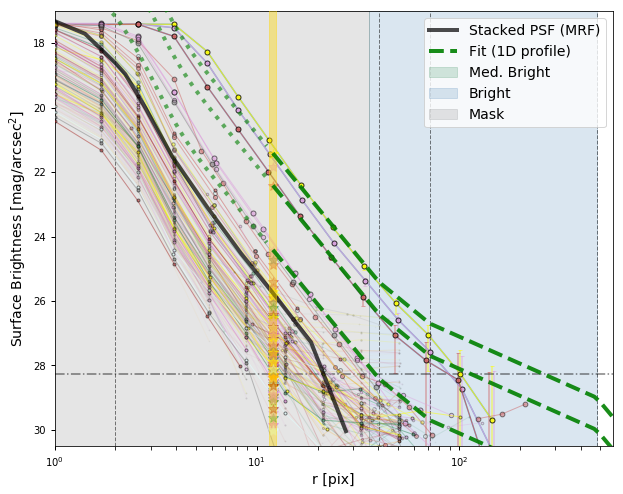

In [22]:
draw_comparison_1D(psf_fit, tab_target, table_res_Rnorm, res_thumb,
                   mags=[11,9,8], local_sky=True, stack_PSF=PSF_JX_p)

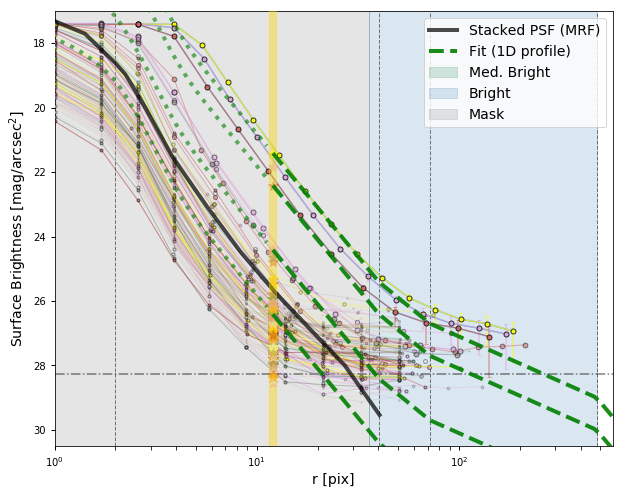

In [25]:
draw_comparison_1D(psf_fit, tab_target, table_res_Rnorm, res_thumb,
                   mags=[13,11,9,8], local_sky=False, stack_PSF=PSF_JX_p)